<a href="https://colab.research.google.com/github/RenukaSiriwardhana/Skin-Cancer-Detection--DermaVision/blob/main/notebooks/implementation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip -q install kaggle

In [9]:
!kaggle datasets download -d ahefatresearch/ham10000-split-and-augmented -p /content --force

Dataset URL: https://www.kaggle.com/datasets/ahefatresearch/ham10000-split-and-augmented
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 2.84G/2.87G [00:22<00:00, 177MB/s]
100% 2.87G/2.87G [00:22<00:00, 137MB/s]


In [10]:
!rm -rf /content/ham10000_dataset
!unzip -q "/content/ham10000-split-and-augmented.zip" -d /content/ham10000_dataset

In [11]:
!ls /content/ham10000_dataset

test_dir  train_dir  val_dir


In [12]:
!ls /content/ham10000_dataset/train_dir

akiec  bcc  bkl  df  mel  nv  vasc


In [13]:
import os

BASE_DIR = "/content/ham10000_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train_dir")
TEST_DIR  = os.path.join(BASE_DIR, "test_dir")

print("Train exists:", os.path.exists(TRAIN_DIR))
print("Test exists :", os.path.exists(TEST_DIR))

print("Train classes:", os.listdir(TRAIN_DIR))
print("Test classes :", os.listdir(TEST_DIR))

Train exists: True
Test exists : True
Train classes: ['bcc', 'mel', 'bkl', 'df', 'vasc', 'akiec', 'nv']
Test classes : ['bcc', 'mel', 'bkl', 'df', 'vasc', 'akiec', 'nv']


In [14]:
import os
import matplotlib.pyplot as plt

BASE_DIR = "/content/ham10000_dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train_dir")
TEST_DIR  = os.path.join(BASE_DIR, "test_dir")

print("TRAIN_DIR exists:", os.path.exists(TRAIN_DIR))
print("TEST_DIR exists :", os.path.exists(TEST_DIR))

train_classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
test_classes  = sorted([d for d in os.listdir(TEST_DIR)  if os.path.isdir(os.path.join(TEST_DIR, d))])

print("Train class folders:", train_classes)
print("Test class folders :", test_classes)
print("Number of classes (train):", len(train_classes))
print("Number of classes (test) :", len(test_classes))

TRAIN_DIR exists: True
TEST_DIR exists : True
Train class folders: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Test class folders : ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Number of classes (train): 7
Number of classes (test) : 7


In [15]:
def count_images_per_class(folder):
    counts = {}
    classes = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg",".jpeg",".png"))]
        counts[cls] = len(imgs)
    return counts

train_counts = count_images_per_class(TRAIN_DIR)
test_counts  = count_images_per_class(TEST_DIR)

print("\nTrain counts per class:")
for k, v in train_counts.items():
    print(f"{k}: {v}")

print("\nTest counts per class:")
for k, v in test_counts.items():
    print(f"{k}: {v}")

print("\nTotal train images:", sum(train_counts.values()))
print("Total test images :", sum(test_counts.values()))
print("Total images (train+test):", sum(train_counts.values()) + sum(test_counts.values()))


Train counts per class:
akiec: 7854
bcc: 7965
bkl: 7944
df: 7377
mel: 7932
nv: 8004
vasc: 7706

Test counts per class:
akiec: 22
bcc: 27
bkl: 66
df: 6
mel: 35
nv: 663
vasc: 9

Total train images: 54782
Total test images : 828
Total images (train+test): 55610


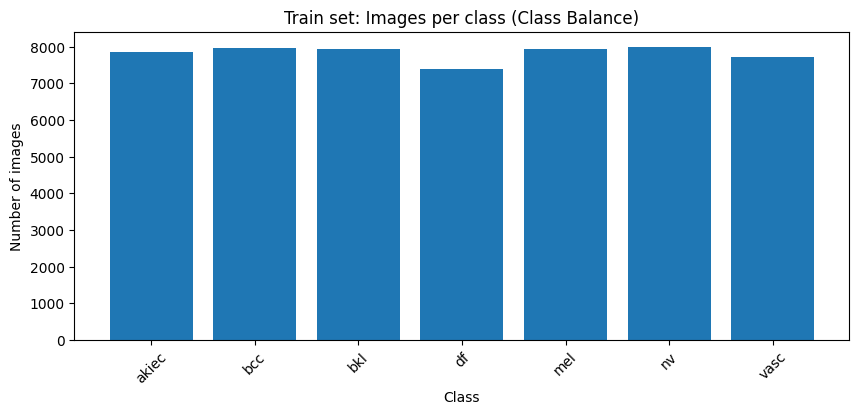

In [16]:
classes = list(train_counts.keys())
values  = list(train_counts.values())

plt.figure(figsize=(10,4))
plt.bar(classes, values)
plt.title("Train set: Images per class (Class Balance)")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks(rotation=45)
plt.show()

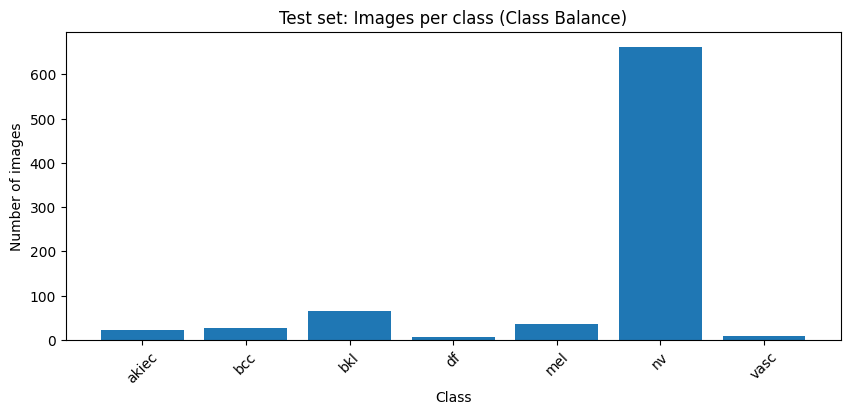

In [17]:
classes_t = list(test_counts.keys())
values_t  = list(test_counts.values())

plt.figure(figsize=(10,4))
plt.bar(classes_t, values_t)
plt.title("Test set: Images per class (Class Balance)")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks(rotation=45)
plt.show()

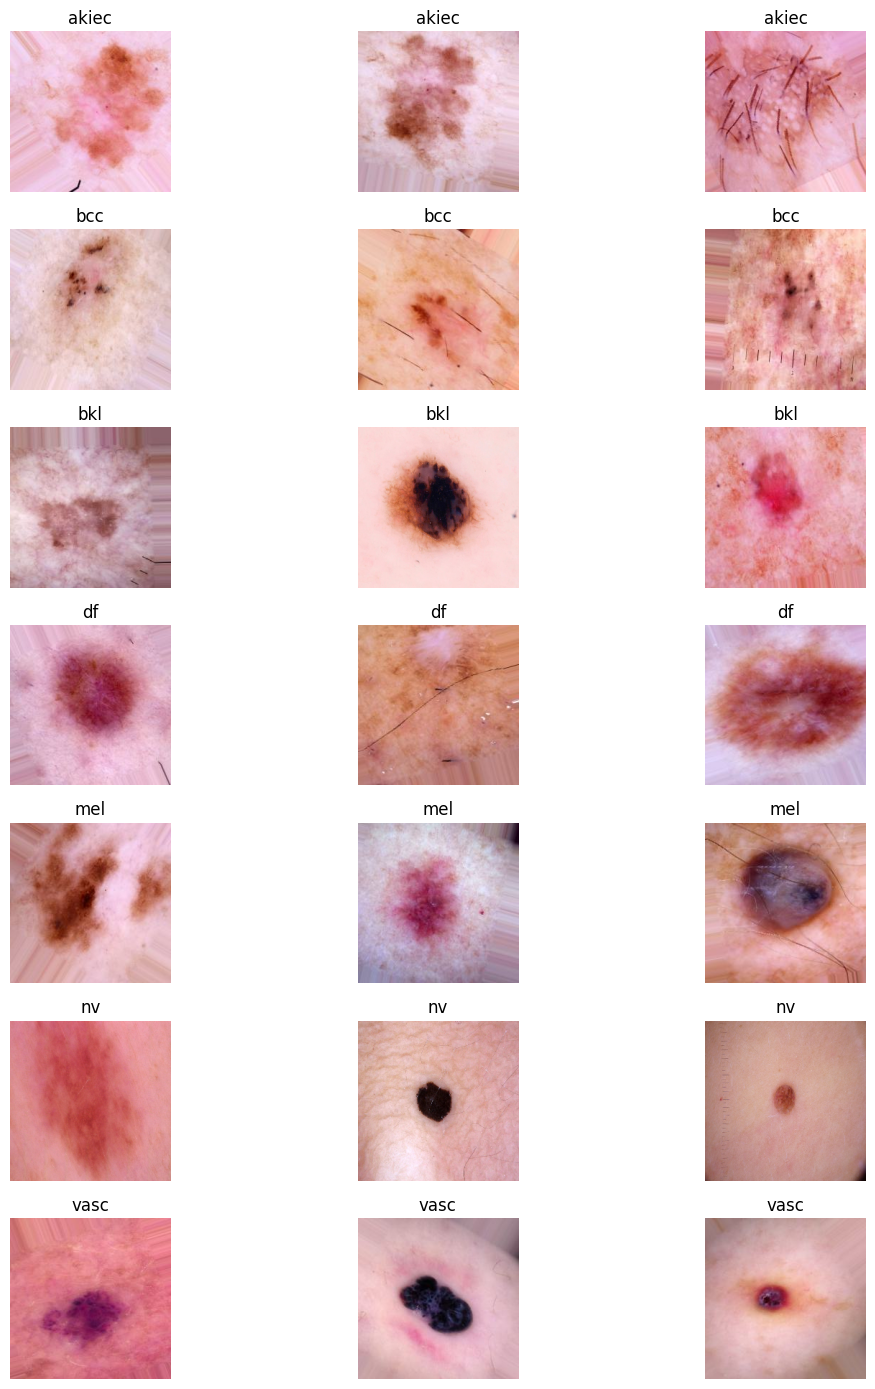

In [18]:
from tensorflow.keras.preprocessing.image import load_img

def show_samples(folder, per_class=2, img_size=(224,224)):
    classes = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
    plt.figure(figsize=(12, 2*len(classes)))
    plot_i = 1

    for cls in classes:
        cls_path = os.path.join(folder, cls)
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg",".jpeg",".png"))]
        imgs = imgs[:per_class]

        for img_name in imgs:
            img_path = os.path.join(cls_path, img_name)
            img = load_img(img_path, target_size=img_size)

            plt.subplot(len(classes), per_class, plot_i)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
            plot_i += 1

    plt.tight_layout()
    plt.show()

show_samples(TRAIN_DIR, per_class=3)

In [19]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
BASE_DIR = "/content/ham10000_dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train_dir")
TEST_DIR  = os.path.join(BASE_DIR, "test_dir")

IMG_SIZE = (224, 224)   # fixed image size
BATCH_SIZE = 32

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,      # normalization
    validation_split=0.2 # 80% train, 20% validation
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [22]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 43829 images belonging to 7 classes.
Found 10953 images belonging to 7 classes.
Found 828 images belonging to 7 classes.


In [23]:
print("Training samples   :", train_generator.samples)
print("Validation samples :", val_generator.samples)
print("Test samples       :", test_generator.samples)

x_batch, y_batch = next(train_generator)

print("Image batch shape :", x_batch.shape)
print("Label batch shape :", y_batch.shape)

print("Class indices:", train_generator.class_indices)

Training samples   : 43829
Validation samples : 10953
Test samples       : 828
Image batch shape : (32, 224, 224, 3)
Label batch shape : (32, 7)
Class indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras import layers

In [25]:
model = Sequential()

# Convolution Block 1
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Convolution Block 2
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Convolution Block 3
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Flatten
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(128, activation='relu'))

# Output Layer (7 classes)
model.add(layers.Dense(7, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model compiled successfully.")

Model compiled successfully.


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 137s 100ms/step - accuracy: 0.9868 - loss: 0.0536 - val_accuracy: 0.5313 - val_loss: 6.6293
Epoch 2/10
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 133s 97ms/step - accuracy: 0.9944 - loss: 0.0184 - val_accuracy: 0.5552 - val_loss: 6.9503
Epoch 3/10
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 133s 97ms/step - accuracy: 0.9944 - loss: 0.0202 - val_accuracy: 0.5235 - val_loss: 6.4860
Epoch 4/10
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 130s 95ms/step - accuracy: 0.9920 - loss: 0.0338 - val_accuracy: 0.5386 - val_loss: 7.0733
Epoch 5/10
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 130s 95ms/step - accuracy: 0.9931 - loss: 0.0295 - val_accuracy: 0.5449 - val_loss: 6.6987
Epoch 6/10
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accuracy: 0.9933 - loss: 0.0262 - val_accuracy: 0.5249 - val_loss: 9.5206
Epoch 7/10
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 132s 96ms/step - accuracy: 0.9936 - loss: 0.0234 - val_accuracy: 0.5346 - val_loss: 7.9961
Epoch 8/10
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 131s 96ms/step - accuracy:

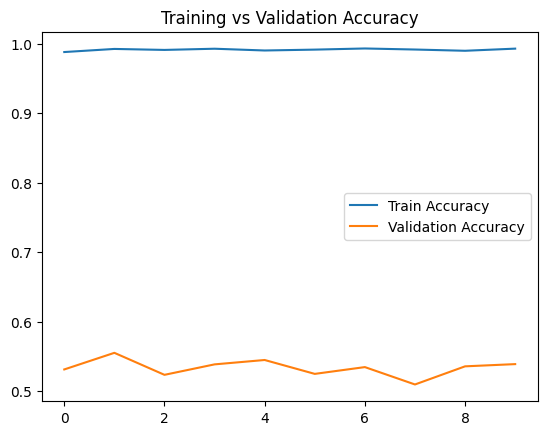

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

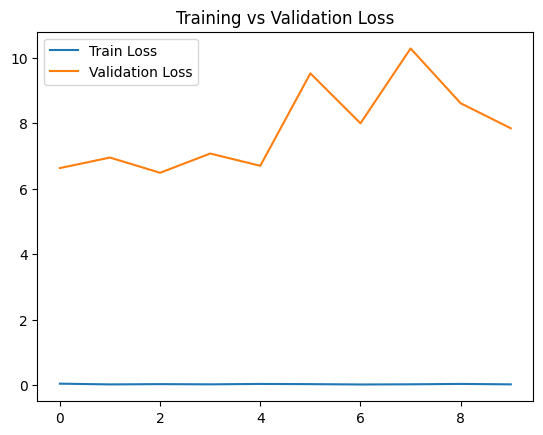

In [42]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()